In [1]:
from pydoc import importfile
import rdflib
import random
import pandas as pd
from sklearn.cluster import KMeans

from rdflib import ConjunctiveGraph
import gc, copy, datetime

import os, sys
p = os.path.abspath('..')
sys.path.insert(1, p)

from knowledge_graph import *

from rdf2vec import RDF2VecTransformer

from lcs_rdf_graph_test import LCS

from rdf_graph_utils import rdf_to_plot, rdf_to_text

import shlex

def rdflib_to_kg_nquads(rdflib_g, label_predicates=[]):
    # Iterate over quads, add s, p and o to graph and 2 edges (s-->p, p-->o)
    # all predicates in label_predicates get excluded
    print(rdflib_g)
    kg = KnowledgeGraph()
    for s, p, o, _ in rdflib_g.quads((None, None, None, None)):
        if p not in label_predicates:
            s_v, o_v = Vertex(str(s)), Vertex(str(o))
            p_v = Vertex(str(p), predicate=True)
            kg.add_vertex(s_v)
            kg.add_vertex(p_v)
            kg.add_vertex(o_v)
            kg.add_edge(s_v, p_v)
            kg.add_edge(p_v, o_v)

    return kg


def get_drug_name(graph, drug):
    query = """
               SELECT ?obj
               WHERE { ?s <http://www.w3.org/2000/01/rdf-schema#label> ?obj.
               """.replace("?s", "<%s>" % drug) + "}"

    query_res = graph.query(query)
    label = []
    for res in query_res:
        label.append(str(res.obj))

    return label


In [2]:
print(end='Loading data... ', flush=True)
g = ConjunctiveGraph()

g.parse('../../datasets/drugbank/drugbank.nq', format="nquads")
print('OK')
#
# # Extract all database drugs' URI
all_drugs_file = pd.read_csv('../../datasets/drugbank/all_drugs.tsv', sep='\t')
all_drugs = [rdflib.URIRef(x) for x in all_drugs_file['drug']]
#
# # Define irrelevant predicates
bad_predicates = pd.read_csv('../../datasets/drugbank/bad_predicates.tsv', sep='\t')
bad_predicates = [rdflib.URIRef(x) for x in bad_predicates['bad_predicates']]
#
# # Define relevant predicates
with open('../../datasets/drugbank/good_predicates.tsv', 'r') as good_predicates:
    gp = good_predicates.read().split()
#

stop_patterns = pd.read_csv('../../datasets/drugbank/stop_patterns.tsv', sep='\t')
stop_patterns = [x for x in stop_patterns['stopping_patterns']]

preds = pd.read_csv('../../datasets/drugbank/uninformative.tsv', sep='\t')
preds = [rdflib.URIRef(x) for x in preds['uninformative']]


Loading data... OK


In [3]:
kg = rdflib_to_kg_nquads(g, label_predicates=bad_predicates)

# del g
# gc.collect()

#
# # %%
# # estraggo un'istanza di knowledge graph per ogni drug presente in quello iniziale

kg_depth = 4

i = 0
j = 0

kv = []
drugs = []
graphs = []

for drug in all_drugs:
    try:
        gi = extract_instance(kg, drug, kg_depth)
        graphs.append(gi)
        drugs.append(drug)
        kv.append({'graph': gi, 'resource': drug})
        i += 1
    except Exception as e:
        j += 1

print('ok:' + str(i))
print('not imported: ' + str(j))

del kg
gc.collect()


[a rdflib:ConjunctiveGraph;rdflib:storage [a rdflib:Store;rdfs:label 'Memory']]
ok:7754
not imported: 5


0

In [4]:
# # Embeddings
transformer = RDF2VecTransformer(wl=False, max_path_depth=4, vector_size=15, walks_per_graph=1)
# transformer = RDF2VecTransformer()
transformer.fit(graphs, drugs)
embeddings = transformer.transform(graphs, drugs)



7754it [00:08, 967.41it/s] 


Extracted 7754 walks for 7754 instances!
Starting Word2Vec Model
Word2Vec Ended
Transform.


In [5]:
# STAMPO PER OGNI RISORSA IL CLUSTER A CUI CORRISPONDE, IN MODO DA POTERNE PRELEVARE PER IL MOMENTO
# DUE APPARTENENTI ALLO STESSO CLUSTER
kmeans = KMeans(n_clusters=250)
km = kmeans.fit(embeddings)
y_kmeans = kmeans.predict(embeddings)

print("clustering models created")

clustering models created


In [6]:

from pathlib import Path


clusters = {i: [] for i in range(kmeans.n_clusters)}
i = 0
for j in y_kmeans:
    clusters[j].append(i)
    i += 1

# Save clusters obtained from kmeans
file = open("../../datasets/drugbank/clusters_log/po_significant/kmeans_125_" + str(datetime.datetime.now()).replace(":", "."), "a")
file.write(str(clusters))
file.close()


In [7]:
# Print clusters and their dimension

for key in clusters.keys():
    print("cluster " + str(key) + " with dimension: " + str(len(clusters[key])))


cluster 0 with dimension: 41
cluster 1 with dimension: 20
cluster 2 with dimension: 27
cluster 3 with dimension: 6
cluster 4 with dimension: 42
cluster 5 with dimension: 40
cluster 6 with dimension: 47
cluster 7 with dimension: 18
cluster 8 with dimension: 35
cluster 9 with dimension: 38
cluster 10 with dimension: 38
cluster 11 with dimension: 36
cluster 12 with dimension: 43
cluster 13 with dimension: 33
cluster 14 with dimension: 7
cluster 15 with dimension: 21
cluster 16 with dimension: 40
cluster 17 with dimension: 32
cluster 18 with dimension: 34
cluster 19 with dimension: 13
cluster 20 with dimension: 51
cluster 21 with dimension: 40
cluster 22 with dimension: 32
cluster 23 with dimension: 16
cluster 24 with dimension: 37
cluster 25 with dimension: 5
cluster 26 with dimension: 48
cluster 27 with dimension: 22
cluster 28 with dimension: 25
cluster 29 with dimension: 28
cluster 30 with dimension: 43
cluster 31 with dimension: 38
cluster 32 with dimension: 49
cluster 33 with dimensi

In [8]:
directory = "../../outputs/drugbank/po_significant/oLast_NQ_NEW_" + str(datetime.datetime.now()).replace(":", ".").replace(" ", "_")
if not os.path.exists(directory):
    os.mkdir(directory)

# cluster da analizzare
# k = 22

# seleziono il cluster con il minor numero di elementi

k = min(clusters.keys(), key=lambda a: len(clusters[a]))

# seleziono il cluster con il minor numero totale di archi

# k = min(clusters.keys(), 
#        key=lambda key: sum(len(kg_to_rdflib(graphs[res], kg_depth)) for res in clusters[key]))

# seleziono il cluster con l'elemento che ha il minor numero di archi

# k = min(clusters.keys(), key=lambda key: min([len(kg_to_rdflib(graphs[res], kg_depth))
#                                                 for res in clusters[key]]))


clusters[k] = sorted(clusters[k],  key=lambda res: len(kg_to_rdflib(graphs[res], kg_depth)))

# clusters[k] = [48, 50]

L = len(clusters[k])

print("esploro il cluster: " + str(k) + " con dimensione " + str(L))
print(clusters[k])
# risorsa iniziale
# resource_1 = random.choice(clusters[k])

resource_1 = clusters[k].pop(0)

graph_1 = graphs[resource_1]

print("risorsa iniziale: " + str(resource_1) + " di dim -> " + str(len(kg_to_rdflib(graph_1, kg_depth))))

# clusters[k].remove(resource_1)
explored_resoures = [resource_1]

iteration = 0



esploro il cluster: 25 con dimensione 5
[3999, 4911, 4915, 2196, 152]
risorsa iniziale: 3999 di dim -> 14


In [9]:
while clusters[k]:
    file = open(directory + "/tmp_LCS.log", "a")
    
    resource_2 = clusters[k].pop(0)
    graph_2 = graphs[resource_2]
    print("LCS with resource: " + str(resource_2) 
          + " con dim: " + str(len(kg_to_rdflib(graph_2, kg_depth))))

    # seed
    seed = LCS(graph_1, graph_2, depth=2, stop_patterns=stop_patterns, uninformative_triples=preds)
    seed.find()
              
    explored_resoures.append(resource_2)
        
    print("dim LCS itermedio tra " + str(explored_resoures) + " \n--> " + str(len(seed)))
        
    del graph_1
    del graph_2
    gc.collect()
        
    graph_1 = copy.deepcopy(seed)

    print("Iterazione: " + str(iteration) + ", trovato LCS tra: " + str(explored_resoures))
    rdf_to_text(seed, directory, "turtle", "tmp_LCS_" + str(iteration))
    rdf_to_text(seed, directory, "nt", "tmp_LCS_" + str(iteration))

    # gestione numero predicato-oggetto significativi
    outputnt = open(directory + '/output_tmp_LCS_' + str(iteration) + '.nt', 'r')
    outputietration =  open(directory + '/output_tmp_LCS_' + str(iteration) + '_po_significant.nt', 'a')
    filecount = 0
    for line in outputnt.readlines():
          line = line.replace('<', '').replace('>', '')
          s, p, o, _ = shlex.split(line)
          if not ('_:blank_' in o) and not ('_:blank_' in p):
                for goodline in gp:
                  if goodline == p:
                      outputietration.write(p + '\n')
                      filecount += 1
    print('Count significant row: ', filecount)
    outputietration.close()
    outputnt.close()
    
      
    del seed
    gc.collect()
        
    file.write("Iterazione: " + str(iteration) +  " risorse esplorate: " + str(explored_resoures) + "\n")
    file.close()
        
    iteration += 1



LCS with resource: 4911 con dim: 35
starting graphs exploration...
exploration ended.
filling LCS graph.
graph completed.
dim LCS itermedio tra [3999, 4911] 
--> 3
Iterazione: 0, trovato LCS tra: [3999, 4911]
Count significant row:  1
LCS with resource: 4915 con dim: 92
starting graphs exploration...
exploration ended.
filling LCS graph.
graph completed.
dim LCS itermedio tra [3999, 4911, 4915] 
--> 3
Iterazione: 1, trovato LCS tra: [3999, 4911, 4915]
Count significant row:  1
LCS with resource: 2196 con dim: 165
starting graphs exploration...
exploration ended.
filling LCS graph.
graph completed.
dim LCS itermedio tra [3999, 4911, 4915, 2196] 
--> 3
Iterazione: 2, trovato LCS tra: [3999, 4911, 4915, 2196]
Count significant row:  1
LCS with resource: 152 con dim: 896
starting graphs exploration...
exploration ended.
filling LCS graph.
graph completed.
dim LCS itermedio tra [3999, 4911, 4915, 2196, 152] 
--> 3
Iterazione: 3, trovato LCS tra: [3999, 4911, 4915, 2196, 152]
Count significa

#### plotting graph ####


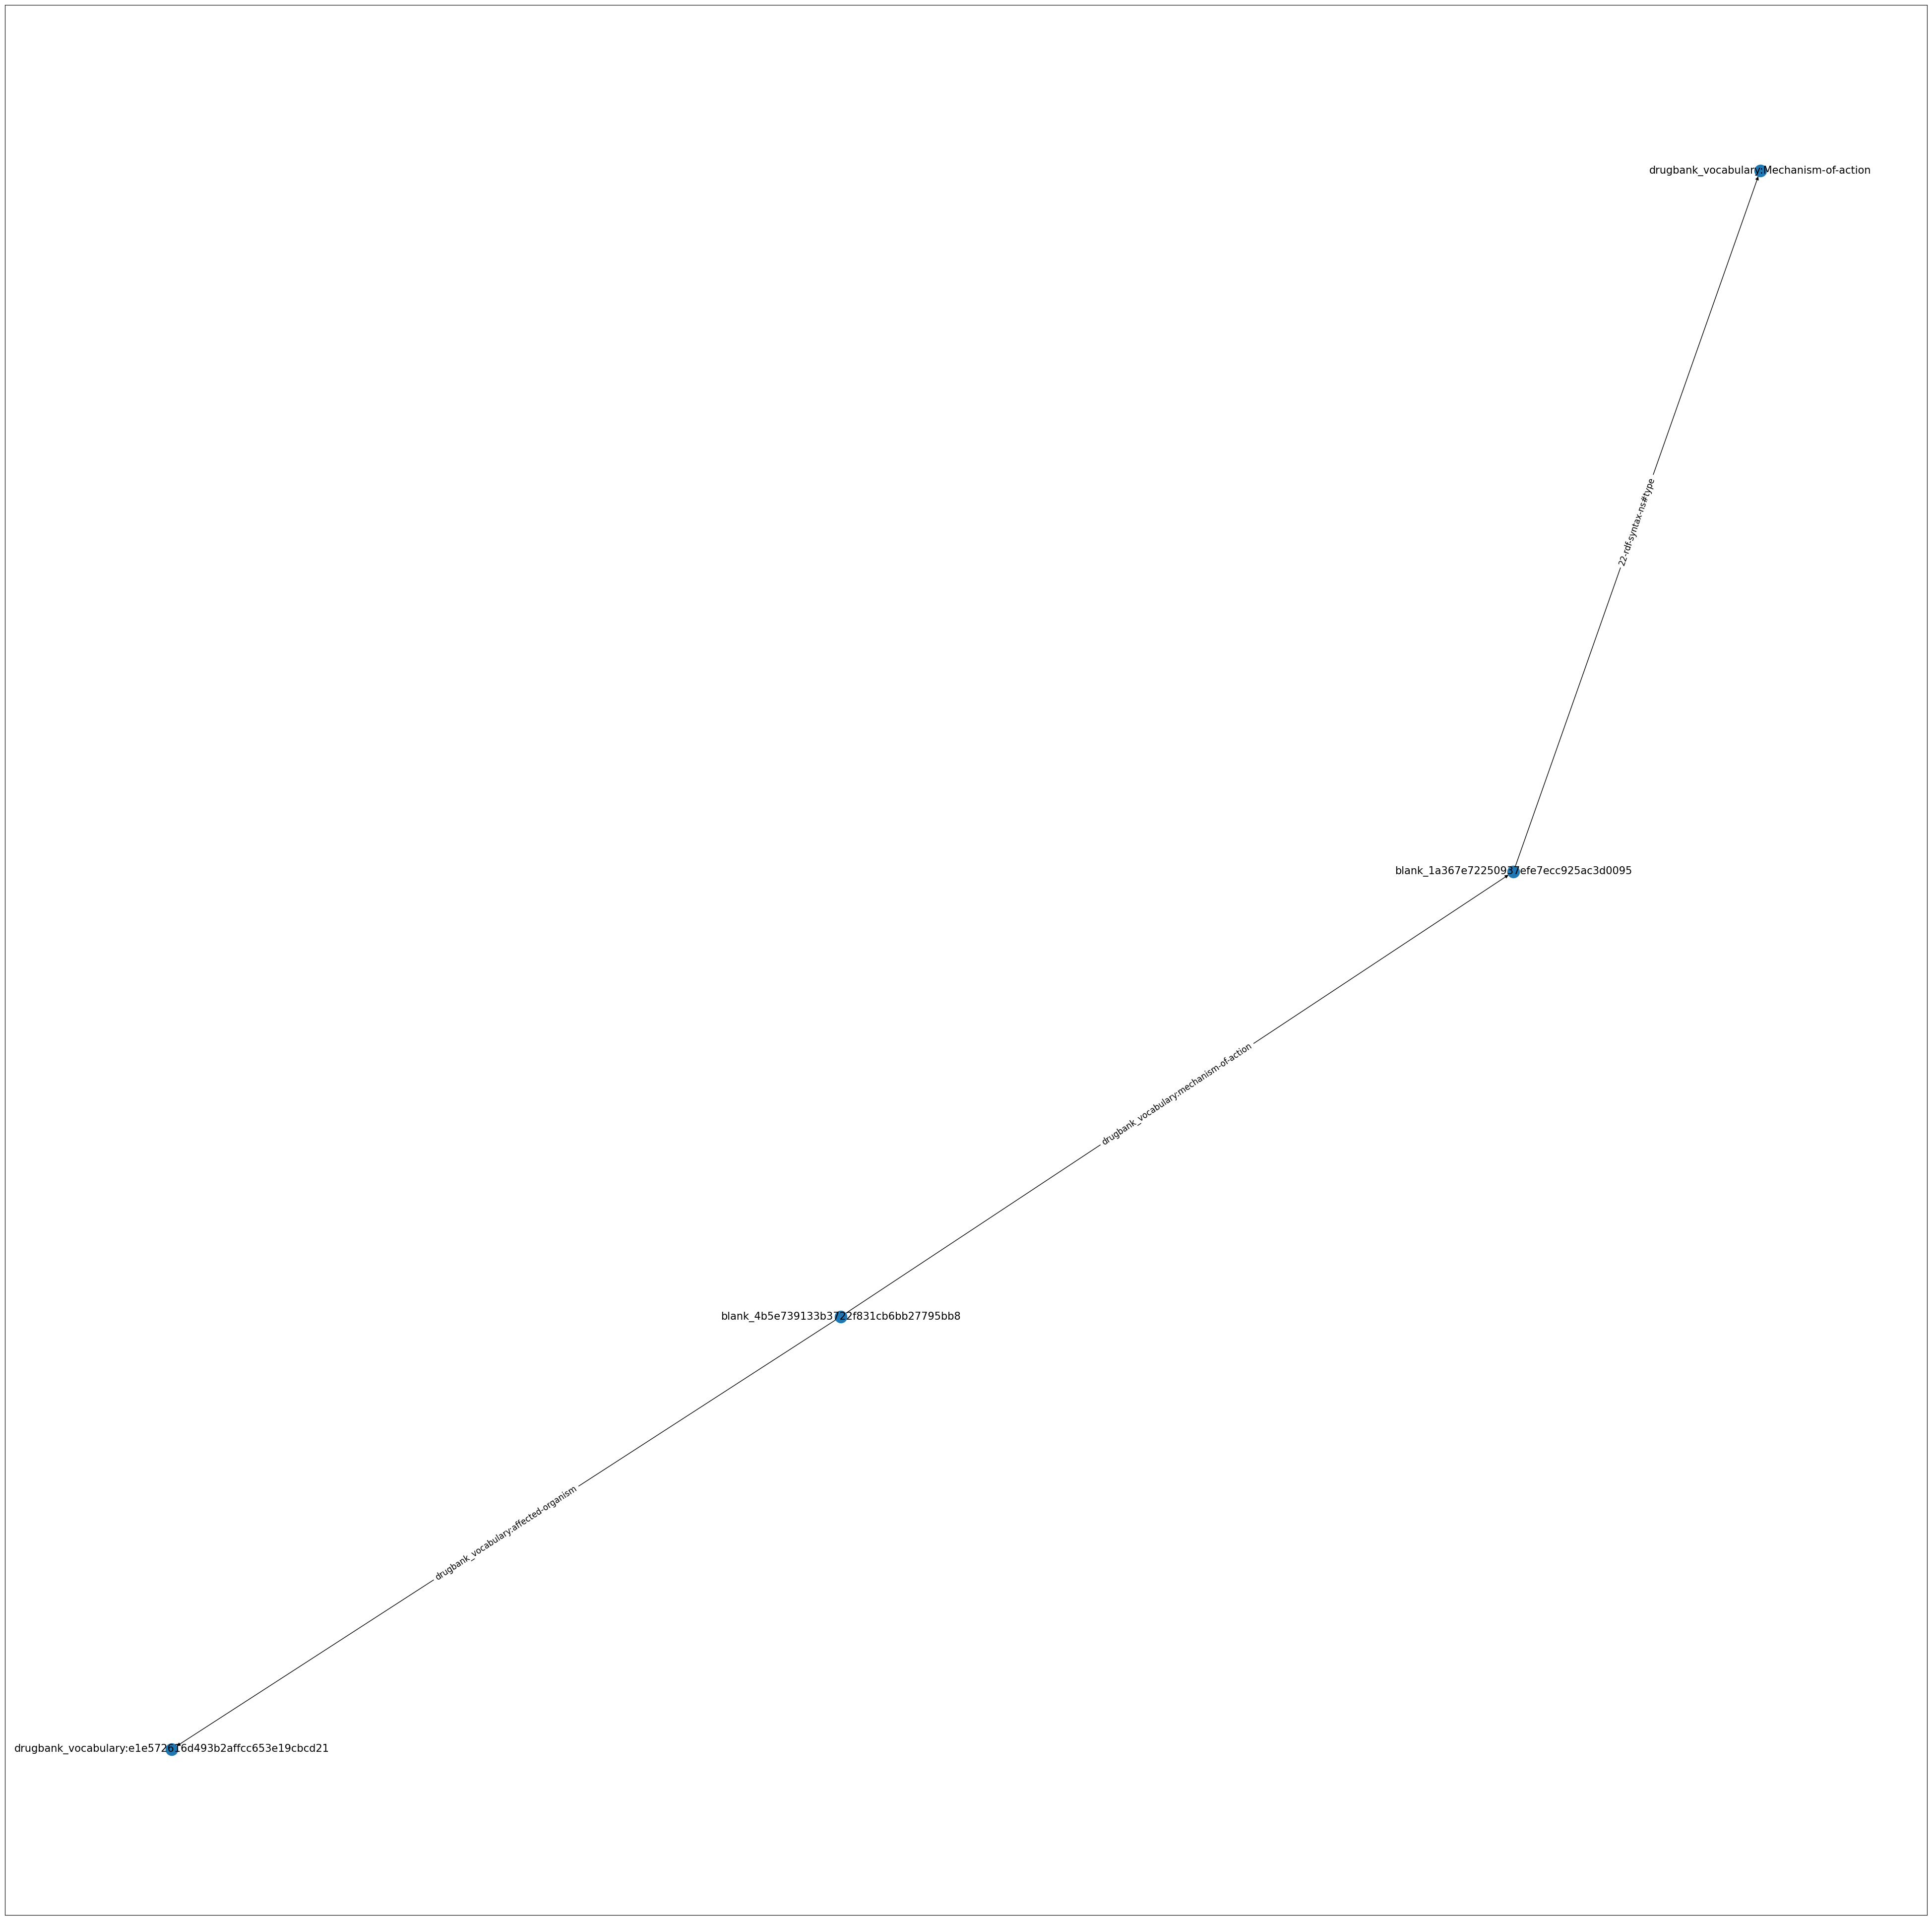

LCS finale tra le risorse: [3999, 4911, 4915, 2196, 152]


In [10]:
rdf_to_plot(graph_1, directory)
print("LCS finale tra le risorse: " + str(explored_resoures))

In [11]:
# SALVATAGGIO DEL GRAFO

rdf_to_text(graph_1, directory, 'turtle', 'final_LCS')
rdf_to_text(graph_1, directory, 'nt', 'final_LCS')
file =  open(directory + "/final_LCS_resources.log", "a")
file.write(str(explored_resoures))

29

In [12]:
file.write("\n ####### \n")

explored_resources_names = []

for drug_index in explored_resoures:
    drug_name = get_drug_name(g, drugs[drug_index])
    explored_resources_names.extend(drug_name)

file.write(str(explored_resources_names))
file.close()

del g
gc.collect()

36590